<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/NelsonSiegelCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
# Install library
!pip install nelson-siegel-svensson

In [ ]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from nelson_siegel_svensson.calibrate import calibrate_ns_ols #Library to use later

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
warnings.filterwarnings('ignore') #Disable warning
plt.style.use('seaborn-deep') #Plot style

In [ ]:
# Define plot function
def plotPD(data, title, label):
  plt.figure(figsize = (10, 6))
  dates = pd.date_range(
    start = '1/1/2014',
    periods = data.shape[0],
    freq = 'Y'
  )
  plt.plot(
    dates,
    data,
    color = 'teal',
    label = f'{label} PD'
  )
  plt.title(title)
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.xlabel('Datetime')
  plt.ylabel('PD')
  plt.legend(frameon = True, facecolor = 'White')
  return plt.show()

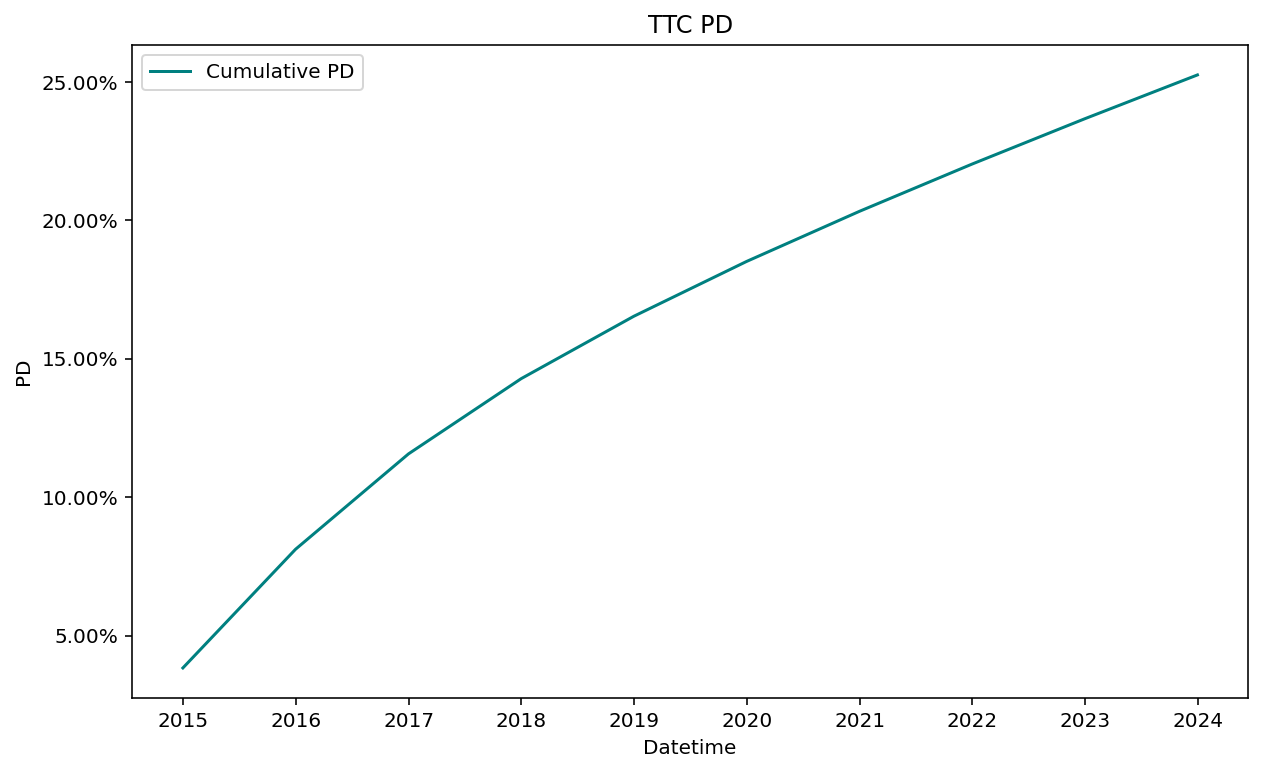

In [ ]:
# Import dataset
# Average TTC PD by risk grade level
df = pd.read_csv(
    'https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/lifetimeMatrix.csv'
).query(
    """
    Segment == 'CU' & Aging == 1
    """ #Select only CU Segment
).drop(
    ['Segment', 'Aging', 'times'],
    axis = 1
)

# Plot
plotPD(df, 'TTC PD', 'Cumulative')

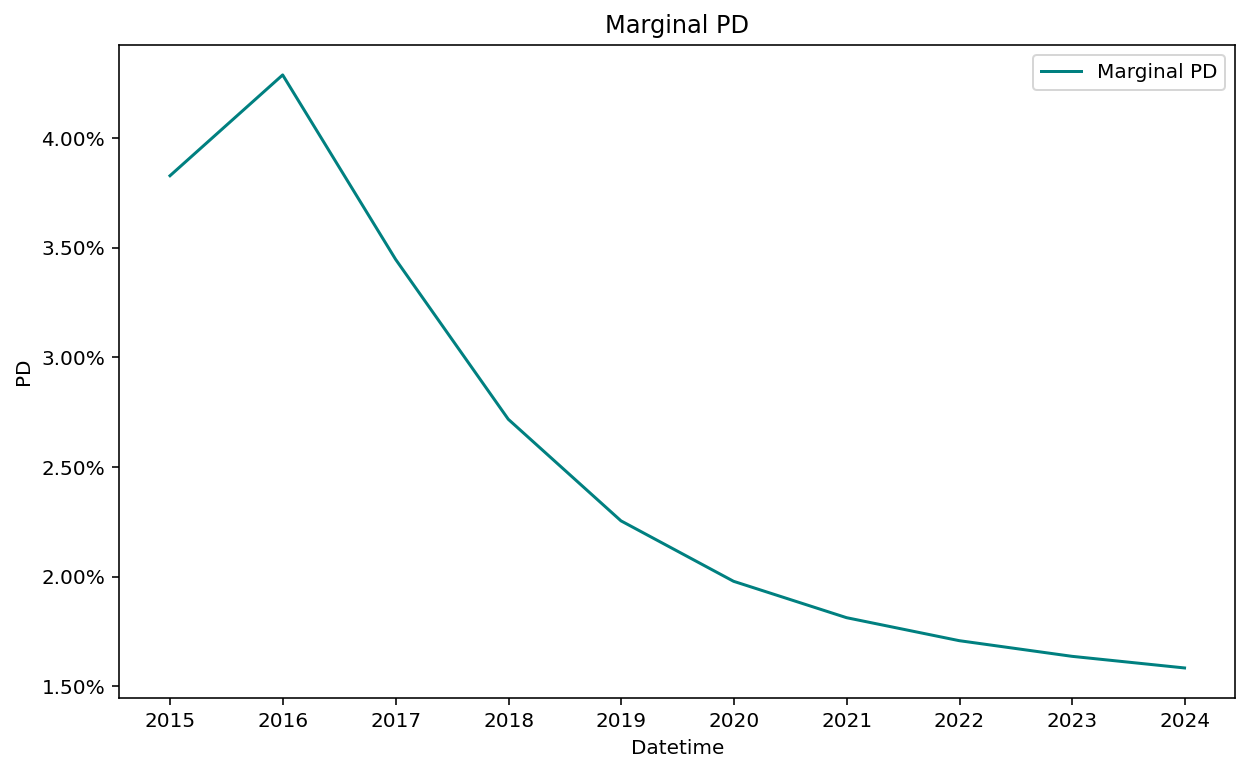

In [ ]:
# To Marginal PD
MarPD = df.diff(
    1,
    axis = 0
).fillna(df.iloc[0])

# Plot
# Plot
plotPD(MarPD, 'Marginal PD', 'Marginal')

### Nelson-Siegel
The Nelson‐Siegel model is widely used in practice for fitting the term structure of interest rates. Historically, one of the most important drivers of return in fixed-income portfolios has been the yield curve, and many investment strategies are expressed in terms of changes in the curve. Any discussion of fixed-income attribution therefore requires an appreciation of how changes in the curve are described, and their effect on the performance of a portfolio.

In the IFRS 9 lifetime term structure PD Model, some of developers have the opinion that the **Marginal lifetime PD** has the similar shape to yield curve. Therefore, the Nelson-Siegel fitting curve method is being leveraged to extrapolate Marginal lifetime PD for a given time.

There are 2 terms of Nelson-Siegel, which are **Nelson-Siegel** and **Nelson-Siegel-Svensson**. The only difference between these two is that the Nelson-Siegel-Svensson allows a 'second hump' term into the formula. However, the Marginal lifetime PD structure should have only one hump. Therefore, the Nelson-Siegel fitting curve method is preferred.

The Nelson-Siegel fitting curve is followed by the below formula:

\begin{align}
        y(t) = \beta_0 + \beta_1\left[\frac{1 - \exp(\frac{-t}{\tau})}{\frac{t}{\tau}}\right] + \beta_2\left[\frac{1 - \exp(\frac{-t}{\tau})}{\frac{t}{\tau}} - \exp(\frac{-t}{\tau})\right]
    \end{align}

where;
- $\beta_0$ is interpreted as the long run levels of interest rates (the loading is 1, it is a constant that does not decay);
- $\beta_1$ is the short-term component (it starts at 1, and decays monotonically and quickly to 0);
- $\beta_2$ is the medium-term component (it starts at 0, increases, then decays to zero);
- $\tau$ is the decay factor: small values produce slow decay and can better fit the curve at long maturities, while large values produce fast decay and can better fit the curve at short maturities;
- $t$ is estimating times




In [ ]:
# Define function Nelson Siegel fitting
def NSFitting(PDData, params, n = None):
  data = np.array(PDData).reshape(-1)
  if n is None:
    n = 0
  t = np.arange(1, data.shape[0] + 1 + n)
  f0 = params[0]
  f1 = params[1] * ((1 - np.exp(-t / params[3])) / t / params[3])
  f2 = params[2] * ((1 - np.exp(-t / params[3])) / t / params[3]) - np.exp(-t / params[3])
  fitted = f0 + f1 + f2
  return fitted

In [ ]:
# Define function Nelson Siegel
def NelsonSiegel(x):
  fitted = NSFitting(MarPD, x)
  error = np.sum((np.array(MarPD).reshape(-1) - fitted) ** 2)
  return error

# Define minimize error
def findParams(x):
  return NelsonSiegel(x)

In [ ]:
# Initial guess
init = np.random.randn(4)

# Set option for iteration
options = {
    'maxiter': 10000,
    'disp': True
} #Increase number of iteration

# Finding parameters for Nelson Siegel
NSEst = minimize(
    findParams,
    init,
    options = options
)
NSEst

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 17
         Function evaluations: 145
         Gradient evaluations: 24


      fun: 4.423725381261219e-06
 hess_inv: array([[ 0.23900774, -0.19468793, -0.19468792, -1.36129375],
       [-0.19468793,  0.70350664, -0.29649339,  1.51696593],
       [-0.19468792, -0.29649339,  0.70350659,  1.51696573],
       [-1.36129375,  1.51696593,  1.51696573, 12.23736668]])
      jac: array([-1.42567274e-08, -7.83283440e-07, -7.83285316e-07,  1.04847715e-06])
  message: 'Optimization terminated successfully.'
     nfev: 145
      nit: 17
     njev: 24
   status: 0
  success: True
        x: array([ 0.00780478,  0.90507716, -0.8811756 ,  0.31570306])

In [ ]:
# Nelson Siegel parameters results
print(f'Beta0: {NSEst.x[0]:.4f}\nBeta1: {NSEst.x[1]:.4f}\nBeta2: {NSEst.x[2]:.4f}\nTau: {NSEst.x[3]:.4f}')

Beta0: 0.0078
Beta1: 0.9051
Beta2: -0.8812
Tau: 0.3157


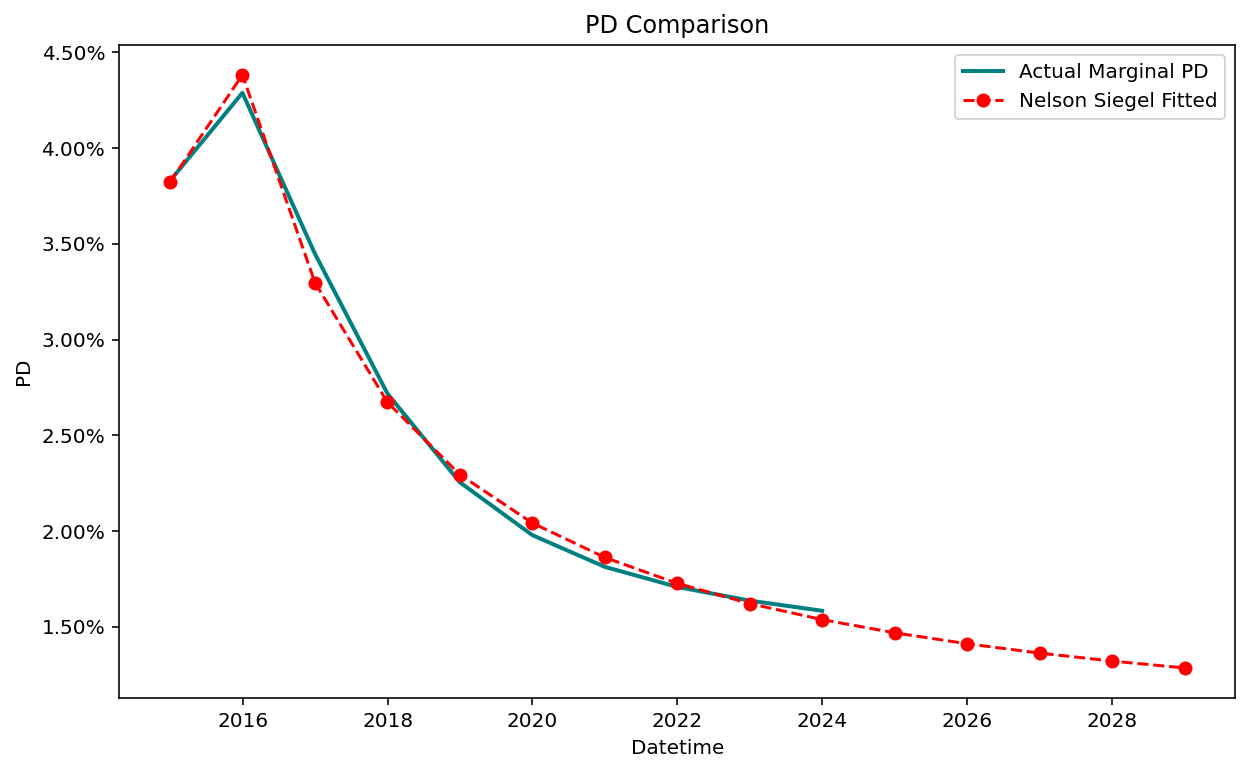

In [ ]:
# Fitted result
NSFitted = NSFitting(MarPD, NSEst.x, n = 5) #Estimate more 5 years

# Define function plot comparison
def plotComp(data1, data2, data3, title, label1, label2, label3):
  plt.figure(figsize = (10, 6))
  plt.plot(
      pd.date_range(
          start = '1/1/2014',
          periods = data1.shape[0],
          freq = 'Y'
      ),
      data1,
      linewidth = 2,
      color = 'teal',
      label = label1
  )
  plt.plot(
      pd.date_range(
          start = '1/1/2014',
          periods = data2.shape[0],
          freq = 'Y'
      ),
      data2,
      linestyle = '--',
      marker = 'o',
      color = 'red',
      label = label2
  )
  if data3 is not None:
      plt.plot(
          pd.date_range(
              start = '1/1/2014',
              periods = data3.shape[0],
              freq = 'Y'
          ),
          data3,
          linestyle = '--',
          marker = 'o',
          color = 'darkgreen',
          label = label3
      )
  plt.title(title)
  plt.gca().set_yticklabels([f'{y * 100:.2f}%' for y in plt.gca().get_yticks()])
  plt.xlabel('Datetime')
  plt.ylabel('PD')
  plt.legend(frameon = True, facecolor = 'White')
  return plt.show()

# Plot comparison
plotComp(
    MarPD,
    NSFitted,
    None,
    'PD Comparison',
    'Actual Marginal PD',
    'Nelson Siegel Fitted',
    None
)

In [ ]:
# Use library
t = np.arange(1, MarPD.shape[0] + 1)
y = np.array(MarPD).reshape(-1)

# Fitting
curve, status = calibrate_ns_ols(
    t,
    y,
    tau0 = 1.0 #Initial guess 1.0 for the optimization of tau
)  

# Result
print(curve)

NelsonSiegelCurve(beta0=0.00685198194788415, beta1=-0.21982669498720553, beta2=0.40554757914573364, tau=0.44088944423356746)


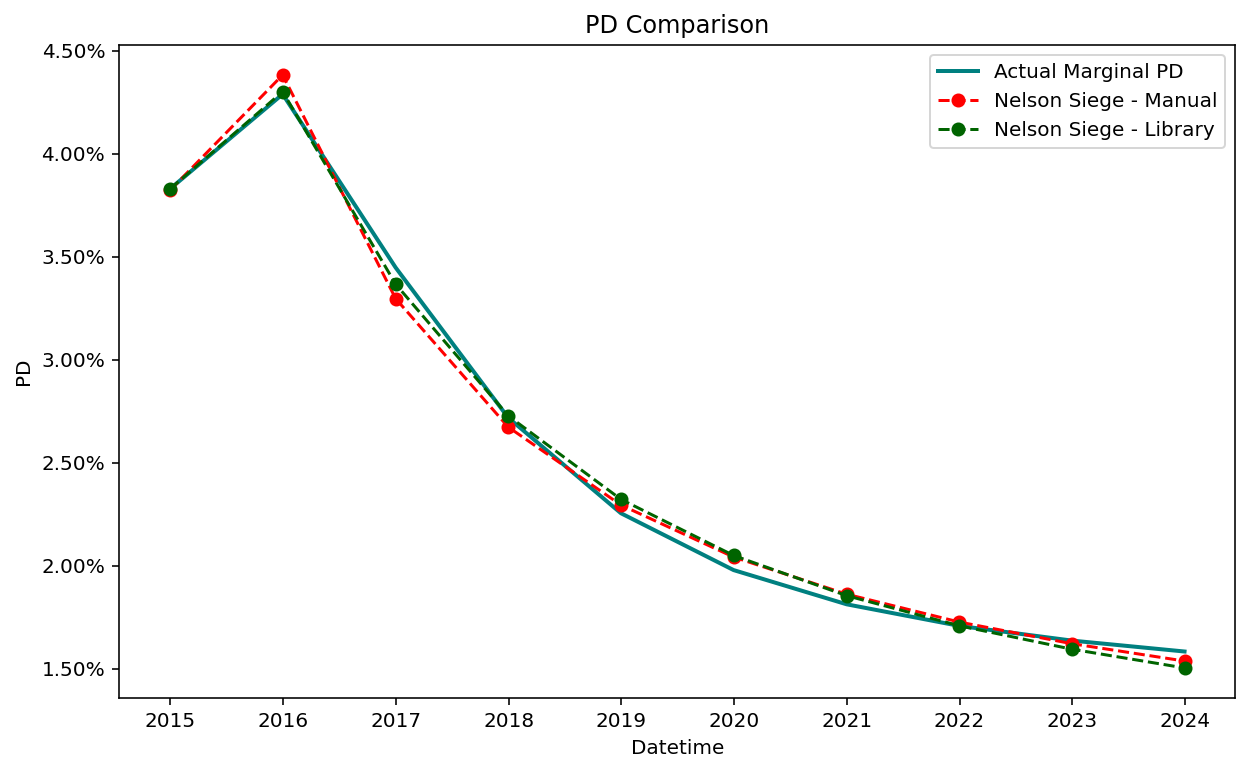

In [ ]:
# Fitted result
manualFit = NSFitting(MarPD, NSEst.x)
fitterFit = curve(t)

# Plot comparison
plotComp(
    MarPD,
    manualFit,
    fitterFit,
    'PD Comparison',
    'Actual Marginal PD',
    'Nelson Siege - Manual',
    'Nelson Siege - Library'
)

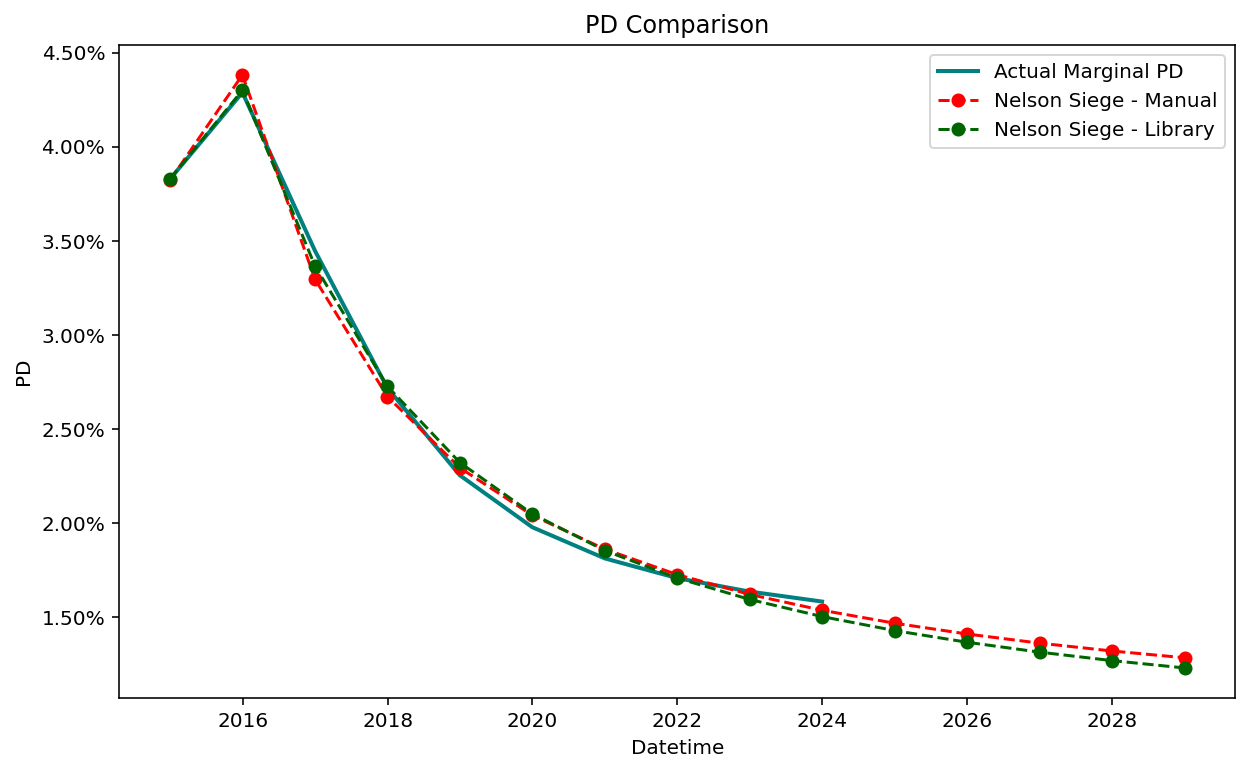

In [ ]:
# Estimate for longer period
manualFit = NSFitting(MarPD, NSEst.x, n = 5)
fitterFit = curve(np.arange(1, MarPD.shape[0] + 6)) #Estimate more 5 years

# Plot comparison
plotComp(
    MarPD,
    manualFit,
    fitterFit,
    'PD Comparison',
    'Actual Marginal PD',
    'Nelson Siege - Manual',
    'Nelson Siege - Library'
)